# Seam Carving 

Ce notebook présente l'utilisation du seam carving version simple et version complexe avec des exemples d'applications. Les fonctions utilisées ont été implémenté dans le fichier seam.py

## Seam Carving version simple

In [5]:
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt

/tmp/ipykernel_31403/2262218661.py:3: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


### Importation de l'image de test

In [20]:
path = '~/projets/Traitement_I/'
name_image_in = 'R.jpg'
name_image_out = 'R_new.png'

image1 = imread(path+name_image_in)

/tmp/ipykernel_31403/2227546284.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imread(path+name_image_in)


### La fonction energy

On fait import de cette fonction à partir de seam.py

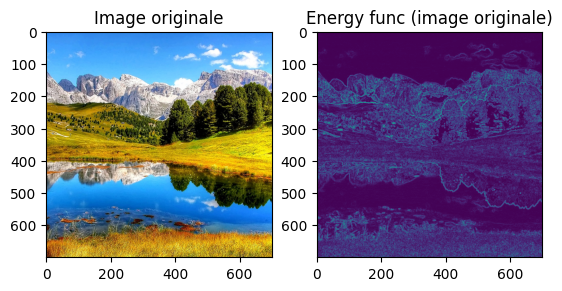

In [21]:
#Fonction d'énergie
from seam import energy_func

# Plot de la fonction energy
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Image originale')

plt.subplot(1, 2, 2)
plt.imshow(energy_func(image1))
plt.title('Energy func (image originale)')

plt.show()


### Application du Seam carving simple 

La fonction crop_c implémentée dans seam.py prend en entrée une image et un echelle entre 0 et 1, et retourne l'image dont la nouvelle largeur est l'ancienne largeur * echelle. Cette fonction fait appelle à la fonction energy et le find seam puis la suppression du seam 

In [4]:
from seam import crop_c

new_image = crop_c(image1, 0.9) 

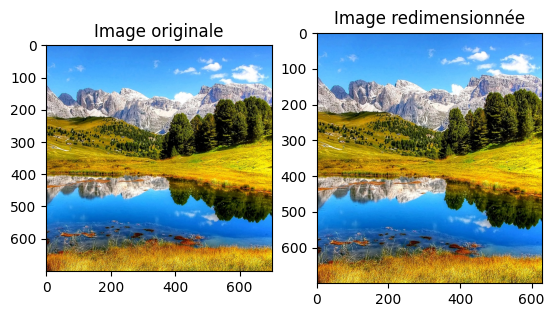

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Image originale')


plt.subplot(1, 2, 2)
plt.imshow(new_image)
plt.title('Image redimensionnée')

plt.show()

## Seam Carving avec détection d'objet
Comme présenté dans le rapport, cette version sera différente de la première par sa fonction de recherche du seam optimal avec contrainte dejà implémenté dans seam.py, et l'utilisation de l'algorithme pré entrainé yolo pour la détection des objets


### Recherche du seam avec contraine

On a choisi une matrice aléatoire et une matrice de contrainte carré K pour valider la fonction de la recherche du seam avec contrainte

In [23]:
from seam import find_seam_with_constraint

In [9]:
# Exemple d'utilisation avec des matrices d'énergie et de contrainte
energy_matrix = np.random.rand(5, 5)  # Remplacez cela par votre propre matrice d'énergie
constraint_matrix = np.zeros((5, 5), dtype=bool)  # Remplacez cela par votre propre matrice de contrainte
for i in range(1,4):
    for j in range(1,4):
        constraint_matrix[i,j] = True 
constraint_matrix[2,2] = False
# Appel de la fonction pour trouver le seam optimal avec contrainte
optimal_seam = find_seam_with_constraint(energy_matrix, constraint_matrix)

# Affichage du seam optimal
print("Seam optimal avec contrainte:", optimal_seam)

Seam optimal avec contrainte: [[4, 3, 2, 1, 0], [1, 0, 0, 0, 1]]


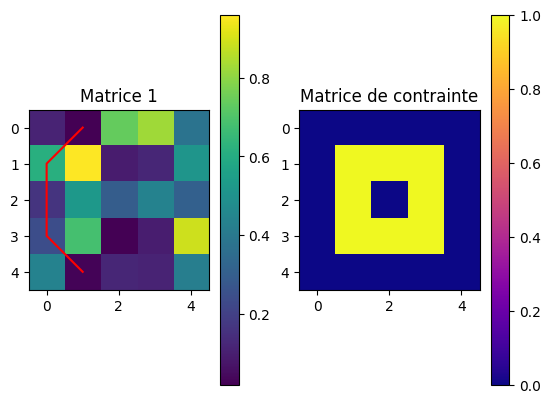

In [10]:
# Tracer la matrice avec une colormap

# Afficher le graphique
plt.subplot(1, 2, 1)
plt.imshow(energy_matrix, cmap='viridis')  # Matrice 1
plt.colorbar()
# Tracer la courbe en rouge
plt.plot(optimal_seam[1], optimal_seam[0], color='red', label='Courbe')
plt.title('Matrice 1')

plt.subplot(1, 2, 2)
plt.imshow(constraint_matrix, cmap='plasma')  # Matrice 2
plt.colorbar()
plt.title('Matrice de contrainte')
plt.show()

# Application avec Yolo
Yolo est algorithme de détection automatique des objets. C'est un modèle de réseau de neurones préentrainé. Pour notre application, on importera la dernière couche de neurone pour détecter les objets dans nos images, avant d'utiliser d'appliquer le seam carving en prenant compte de l'objet

Assurer vous de cloner le dossier darknet à partir du github en utilisant la commande suivante :
```
git clone https://github.com/pjreddie/darknet
cd darknet
make 
```

In [1]:
import cv2

# Charger le modèle YOLO pré-entrainé
net = cv2.dnn.readNet('darknet/yolov3.weights', 'darknet/cfg/yolov3.cfg')

# Charger les noms des classes (coco.names contient les noms des classes)
with open('darknet/data/coco.names', 'r') as f:
    classes = f.read().strip().split('\n')

In [6]:
# fonction de détection d'objet

def yolo_dt(image):
    # Obtenir les dimensions de l'image
    height, width = image.shape[:2]

    # Prétraiter l'image pour l'entrée du réseau YOLO
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Obtenir les noms des couches de sortie
    output_layers = net.getUnconnectedOutLayersNames()

    # Faire passer l'image à travers le réseau
    outs = net.forward(output_layers)

    # Initialiser des listes pour les boîtes, les confidences et les classes
    boxes = []
    confidences = []
    class_ids = []

    # Filtrer les détections basées sur les confiances
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Filtrer les détections peu fiables
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Coordonnées de la boîte
                x = int(center_x - w/2)
                y = int(center_y - h/2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Supprimer les détections en double
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    return indices, boxes, confidences, class_ids    

In [7]:
# Dessiner les boîtes et les étiquettes sur l'image
def image_objet(data, image):
    indices, boxes, confidences, class_ids = data
    for i in indices:
        #i = i[0]
        x, y, w, h = boxes[i]
        label = classes[class_ids[i]]
        confidence = confidences[i]

        # Dessiner la boîte et l'étiquette
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, f'{label} {confidence:.2f}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

### Exemple d'application sur l'image de bird

/tmp/ipykernel_31403/2184873972.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imread(path+name_image_in)


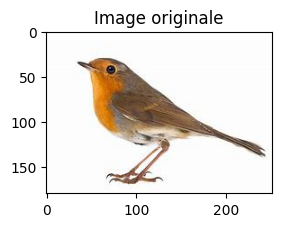

In [12]:
path = '~/projets/Traitement_I/'
name_image_in = 'OIP.jpg'
name_image_out = 'OIP_new.jpg'

image2 = imread(path+name_image_in)
image_ori = image2
plt.subplot(1, 2, 1)
plt.imshow(image2)
plt.title('Image originale')
plt.show()


In [9]:
# Détection de l'objet avec yolo (ça peut prendre un peu du temps )

mes_data = yolo_dt(image2)

In [10]:
image_cadré = image2
image_objet(mes_data, image_cadré)

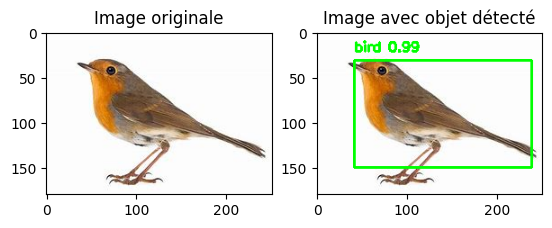

In [13]:
plt.subplot(1, 2, 1)
plt.imshow(image_ori)
plt.title('Image originale')


plt.subplot(1, 2, 2)
plt.imshow(image_cadré)
plt.title('Image avec objet détecté')

plt.show()

## Application de seam carving avec contrainte

In [15]:
# Définition de la matrice de contrainte
boxess = mes_data[1]
x, y, w, h = boxess[0]
n,m,nn = np.shape(image2)
KKK = np.zeros((n,m))
for i in range(y,y+h):
    for j in range(x,x+w):
        KKK[i,j] = True 

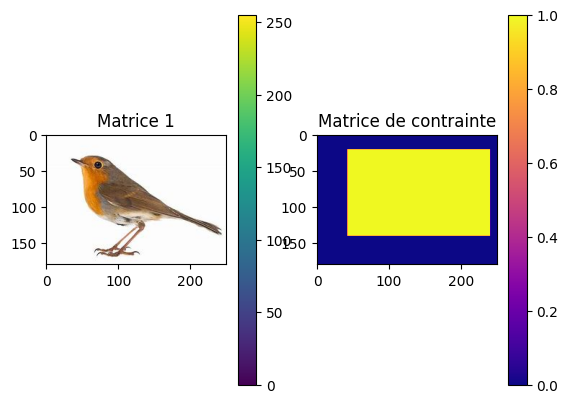

In [17]:
# Afficher le graphique
plt.subplot(1, 2, 1)
plt.imshow(image2, cmap='viridis')  # Matrice 1
plt.colorbar()
plt.title('Matrice 1')

plt.subplot(1, 2, 2)
plt.imshow(KKK, cmap='plasma')  # Matrice 2
plt.colorbar()
plt.title('Matrice de contrainte')
plt.show()

In [24]:
image2_enr = energy_func(image2)
Bird_opt_seam = find_seam_with_constraint(image2_enr, KKK)

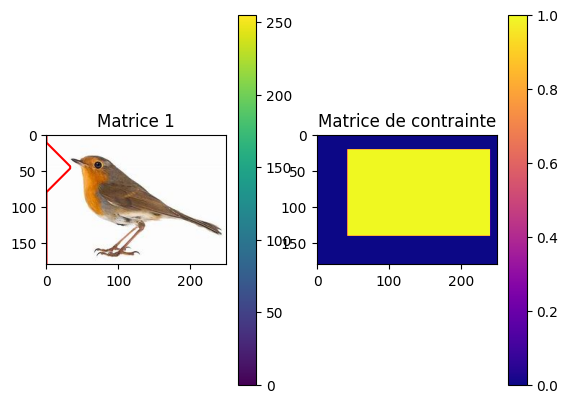

In [26]:
# Afficher le graphique
plt.subplot(1, 2, 1)
plt.imshow(image2, cmap='viridis')  # Matrice 1
plt.colorbar()
# Tracer la courbe en rouge
plt.plot(Bird_opt_seam[1], Bird_opt_seam[0], color='red', label='Courbe')
plt.title('Matrice 1')

plt.subplot(1, 2, 2)
plt.imshow(KKK, cmap='plasma')  # Matrice 2
plt.colorbar()
plt.title('Matrice de contrainte')
plt.show()

### On importe crop_cc de seam.py

In [27]:
from seam import crop_cc
new_im = crop_cc(image_ori, KKK,0.9)

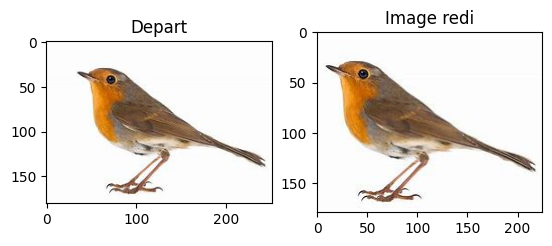

In [28]:
# Afficher le graphique
plt.subplot(1, 2, 1)
plt.imshow(image2, cmap='viridis')  # 
plt.title('Depart')

plt.subplot(1, 2, 2)
plt.imshow(new_im, cmap='plasma')  # Matrice 2
plt.title('Image redi')
plt.show()

# FIN 